In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# file_path = '/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv'
file_path = 'dat_train1.csv'

df = pd.read_csv(file_path)


In [4]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

In [5]:
df.head()

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,id,sep
0,15849251,383997507,4,browse_products,2021-11-04 14:11:15+00:00,1,15849251 383997507,-
1,15849251,383997507,4,browse_products,2021-11-04 14:11:29+00:00,2,15849251 383997507,-
2,15849251,383997507,4,browse_products,2021-11-04 14:12:10+00:00,3,15849251 383997507,-
3,15849251,383997507,4,browse_products,2021-11-04 14:12:21+00:00,4,15849251 383997507,-
4,15849251,383997507,4,browse_products,2021-11-04 14:12:24+00:00,5,15849251 383997507,-


In [6]:
# 1. How many rows
row_count = len(df)

# 2. How many unique IDs
unique_ids = df['id'].nunique()

# 3. Earliest and latest timestamp
earliest_ts = df['event_timestamp'].min()
latest_ts = df['event_timestamp'].max()

print(f"Total Rows: {row_count}")
print(f"Unique IDs: {unique_ids}")
print(f"Earliest Timestamp: {earliest_ts}")
print(f"Latest Timestamp: {latest_ts}")

Total Rows: 54960961
Unique IDs: 1430445
Earliest Timestamp: 2020-11-03 03:31:30+00:00
Latest Timestamp: 2023-01-23 12:29:56+00:00


In [7]:
# define a duplicate as same user, same action, same time
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
num_duplicates = duplicate_mask.sum()
total_rows_before = len(df)
proportion_duplicates = num_duplicates / total_rows_before

In [8]:
# remove duplicates
df_clean = df[~duplicate_mask].copy()
total_rows_after = len(df_clean)

# fix action counter (journey_steps_until_end)
# sort by customer and time, then group by customer to re-assign the step numbers
df_clean = df_clean.sort_values(by=['customer_id', 'event_timestamp'])
df_clean['journey_steps_until_end'] = df_clean.groupby('customer_id').cumcount() + 1


print(f"Total duplicates found: {num_duplicates}")
print(f"Proportion of duplicates: {proportion_duplicates:.4%}")
print(f"Rows after deleting duplicates: {total_rows_after}")

Total duplicates found: 3112139
Proportion of duplicates: 5.6625%
Rows after deleting duplicates: 51848822


In [9]:
df_clean.head()

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,id,sep
34894898,-2147483541,2059949086,12,application_web_approved,2021-10-05 08:11:26+00:00,1,-2147483541 2059949086,-
34894899,-2147483541,2059949086,5,view_cart,2021-10-05 08:17:10+00:00,2,-2147483541 2059949086,-
34894900,-2147483541,2059949086,4,browse_products,2021-10-05 08:21:31+00:00,3,-2147483541 2059949086,-
34894901,-2147483541,2059949086,11,add_to_cart,2021-10-05 08:21:59+00:00,4,-2147483541 2059949086,-
34894902,-2147483541,2059949086,5,view_cart,2021-10-05 08:22:17+00:00,5,-2147483541 2059949086,-


In [10]:
journey_stats = df_clean.groupby('customer_id').agg(
    total_actions=('journey_steps_until_end', 'max'),
    start_time=('event_timestamp', 'min'),
    end_time=('event_timestamp', 'max')
)

In [11]:
journey_stats['duration'] = journey_stats['end_time'] - journey_stats['start_time']

In [12]:
print("Typical Journey (Actions):", journey_stats['total_actions'].median())
print("Typical Journey (Time):", journey_stats['duration'].median())

Typical Journey (Actions): 25.0
Typical Journey (Time): 107 days 02:56:27


In [13]:
df_clean['time_diff'] = df_clean.groupby('customer_id')['event_timestamp'].diff()

In [14]:
# Conversion Rates

conversion_event = 'order_shipped'

# count unique customers who converted
converted_customers = df_clean[df_clean['event_name'] == conversion_event]['customer_id'].nunique()
total_customers = df_clean['customer_id'].nunique()

conversion_rate = (converted_customers / total_customers) * 100

print(f"Total Customers: {total_customers}")
print(f"Converted Customers: {converted_customers}")
print(f"Conversion Rate: {conversion_rate:.2f}%")

Total Customers: 1391421
Converted Customers: 278243
Conversion Rate: 20.00%


In [15]:
df_clean['hour'] = df_clean['event_timestamp'].dt.hour

In [16]:
# helper columns to make aggregation easier
df_clean['is_appl_submit'] = (df_clean['event_name'] == 'application_web_submit').astype(int)
df_clean['is_shipped'] = (df_clean['event_name'] == 'order_shipped').astype(int)
df_clean['is_add_to_cart'] = (df_clean['event_name'] == 'add_to_cart').astype(int)
df_clean['is_browse'] = (df_clean['event_name'] == 'browse_products').astype(int)

In [17]:
df_flat = df_clean.groupby('customer_id').agg(
    total_actions=('journey_steps_until_end', 'max'),
    start_time=('event_timestamp', 'min'),
    end_time=('event_timestamp', 'max'),
    has_applied=('is_appl_submit', 'max'),
    has_shipped=('is_shipped', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'), # total times they clicked 'add'
    num_unique_products=('is_browse', 'sum')      # count of browsing events
).reset_index()

In [18]:
# duration in seconds
df_flat['journey_duration_sec'] = (df_flat['end_time'] - df_flat['start_time']).dt.total_seconds()

# actions per hour
# add a 1-second buffer to avoid division by 0
df_flat['actions_per_hour'] = df_flat['total_actions'] / ((df_flat['journey_duration_sec'] + 1) / 3600)

# start hour
df_flat['start_hour'] = df_flat['start_time'].dt.hour

df_flat = df_flat.drop(columns=['start_time', 'end_time'])

In [19]:
df_flat.head()

,customer_id,total_actions,has_applied,has_shipped,max_items_in_cart,num_unique_products,journey_duration_sec,actions_per_hour,start_hour
0,-2147483541,29,0,0,4,4,20645894.0,0.005057,8
1,-2147474305,32,1,0,0,1,16939969.0,0.006800,22
2,-2147466542,12,0,0,1,1,13597487.0,0.003177,22
3,-2147464266,9,1,0,0,0,87.0,368.181818,9
4,-2147459085,41,1,0,4,19,18863502.0,0.007825,15


In [20]:
# 1. Determine the "Current Date" (latest time in the dataset)
max_date = df_clean['event_timestamp'].max()

# 2. Get the last event for every customer
last_event_per_user = df_clean.sort_values('event_timestamp').groupby('customer_id').tail(1)

# 3. Identify Successful customers (those who ever had an order shipped)
success_ids = set(df_clean[df_clean['event_name'] == 'order_shipped']['customer_id'])

def categorize_journey(row):
    # If they ever ordered, it's a Success
    if row['customer_id'] in success_ids:
        return 'Successful'
    
    # Check inactivity: Difference between their last action and the end of the dataset
    inactivity_period = max_date - row['event_timestamp']
    if inactivity_period >= pd.Timedelta(days=60):
        return 'Incomplete (Lapsed)'
    
    return 'Active/Other'

last_event_per_user['outcome'] = last_event_per_user.apply(categorize_journey, axis=1)

In [21]:
last_event_per_user.head()

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,id,sep,time_diff,hour,is_appl_submit,is_shipped,is_add_to_cart,is_browse,outcome
28954416,776951101,-918220714,28,order_shipped,2020-11-26 00:00:00+00:00,16,776951101 -918220714,-,5 days 13:26:04,0,0,1,0,0,Successful
23187670,-1337252997,749153847,28,order_shipped,2020-12-10 00:00:00+00:00,195,-1337252997 749153847,-,0 days 04:29:36,0,0,1,0,0,Successful
29782735,421554140,113015830,28,order_shipped,2020-12-15 00:00:00+00:00,23,421554140 113015830,-,0 days 21:04:06,0,0,1,0,0,Successful
41872880,-1142127835,-1367340638,28,order_shipped,2020-12-17 00:00:00+00:00,49,-1142127835 -1367340638,-,17 days 01:52:36,0,0,1,0,0,Successful
8926905,839837639,-995323263,6,begin_checkout,2021-01-02 01:05:45+00:00,17,839837639 -995323263,-,0 days 00:00:07,1,0,0,0,0,Incomplete (Lapsed)


In [22]:
df_final = df_flat.merge(last_event_per_user[['customer_id', 'outcome']], on='customer_id')

In [23]:
df_final.head()

,customer_id,total_actions,has_applied,has_shipped,max_items_in_cart,num_unique_products,journey_duration_sec,actions_per_hour,start_hour,outcome
0,-2147483541,29,0,0,4,4,20645894.0,0.005057,8,Incomplete (Lapsed)
1,-2147474305,32,1,0,0,1,16939969.0,0.006800,22,Incomplete (Lapsed)
2,-2147466542,12,0,0,1,1,13597487.0,0.003177,22,Incomplete (Lapsed)
3,-2147464266,9,1,0,0,0,87.0,368.181818,9,Incomplete (Lapsed)
4,-2147459085,41,1,0,4,19,18863502.0,0.007825,15,Incomplete (Lapsed)


In [24]:
# Grouping by the new outcome labels
task_1_summary = df_final[df_final['outcome'].isin(['Successful', 'Incomplete (Lapsed)'])].groupby('outcome').agg({
    'total_actions': 'mean',
    'journey_duration_sec': 'mean',
    'num_unique_products': 'mean',
    'has_applied': 'mean'
}).round(2)

print(task_1_summary)

                     total_actions  journey_duration_sec  num_unique_products  \
outcome                                                                         
Incomplete (Lapsed)          31.12           15037521.18                10.63   
Successful                   56.48            5411687.23                23.44   

                     has_applied  
outcome                           
Incomplete (Lapsed)         0.39  
Successful                  0.43  


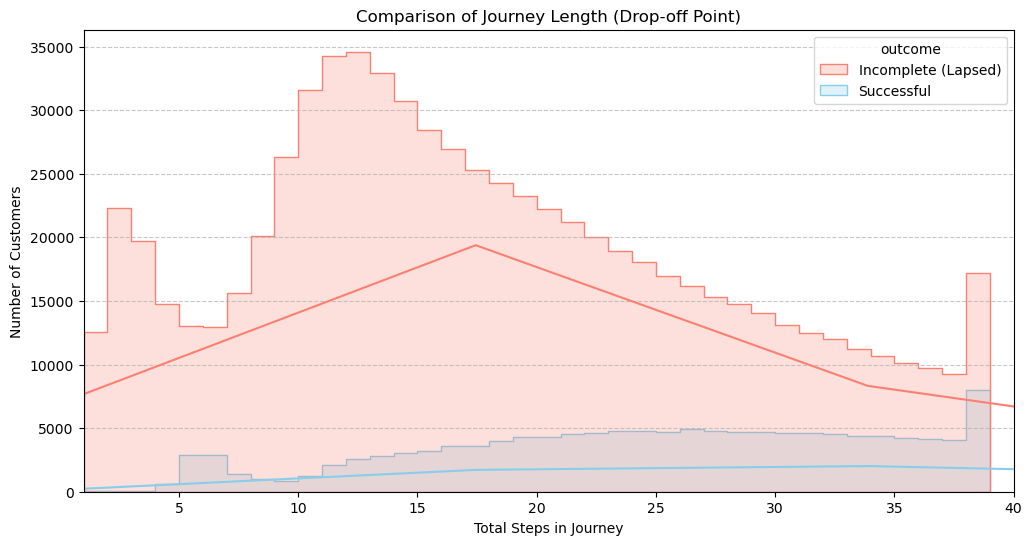

In [25]:
# Filter for only the two main groups we are comparing
df_viz = df_final[df_final['outcome'].isin(['Successful', 'Incomplete (Lapsed)'])]

plt.figure(figsize=(12, 6))
sns.histplot(data=df_viz, x='total_actions', hue='outcome', 
             bins=range(1, 40), kde=True, element="step", palette=['salmon', 'skyblue'])

plt.title('Comparison of Journey Length (Drop-off Point)')
plt.xlabel('Total Steps in Journey')
plt.ylabel('Number of Customers')
plt.xlim(1, 40) # Focus on the first 40 steps where the most movement happens
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/var/folders/9d/172d12fx165by8w23sfqj4400000gn/T/ipykernel_12958/3768874027.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='outcome', y='num_unique_products', data=df_viz,


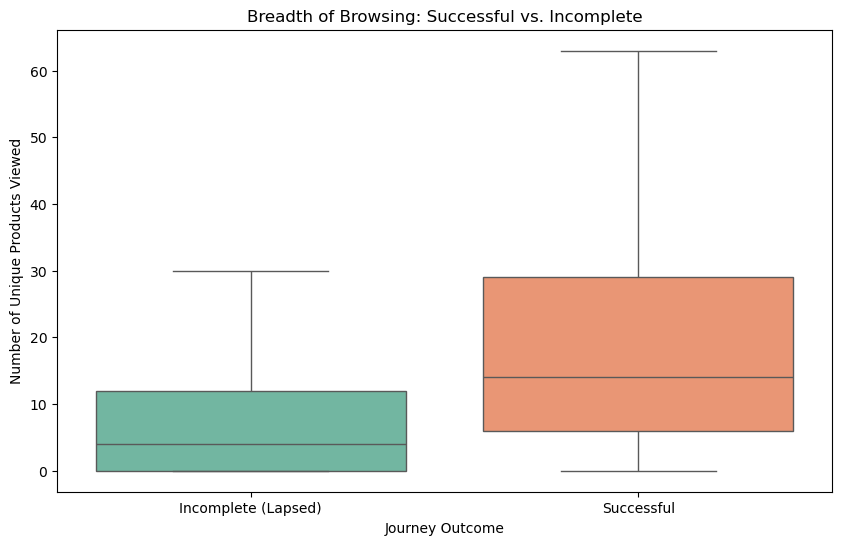

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='outcome', y='num_unique_products', data=df_viz, 
            showfliers=False, palette='Set2')

plt.title('Breadth of Browsing: Successful vs. Incomplete')
plt.ylabel('Number of Unique Products Viewed')
plt.xlabel('Journey Outcome')
plt.show()

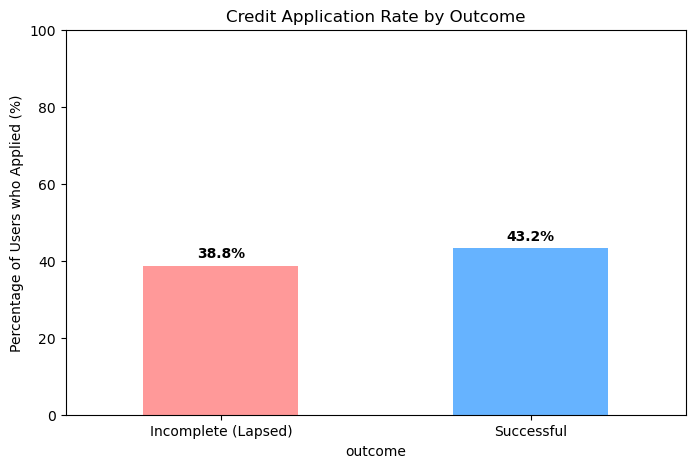

In [27]:
# Calculate rates for the plot
app_rates = df_viz.groupby('outcome')['has_applied'].mean() * 100

plt.figure(figsize=(8, 5))
app_rates.plot(kind='bar', color=['#ff9999','#66b3ff'])

plt.title('Credit Application Rate by Outcome')
plt.ylabel('Percentage of Users who Applied (%)')
plt.xticks(rotation=0)
plt.ylim(0, 100) # Keep scale to 100 to show context

# Add text labels on top of bars
for i, v in enumerate(app_rates):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()

/var/folders/9d/172d12fx165by8w23sfqj4400000gn/T/ipykernel_12958/2271169412.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='outcome', y='duration_days', data=df_viz,


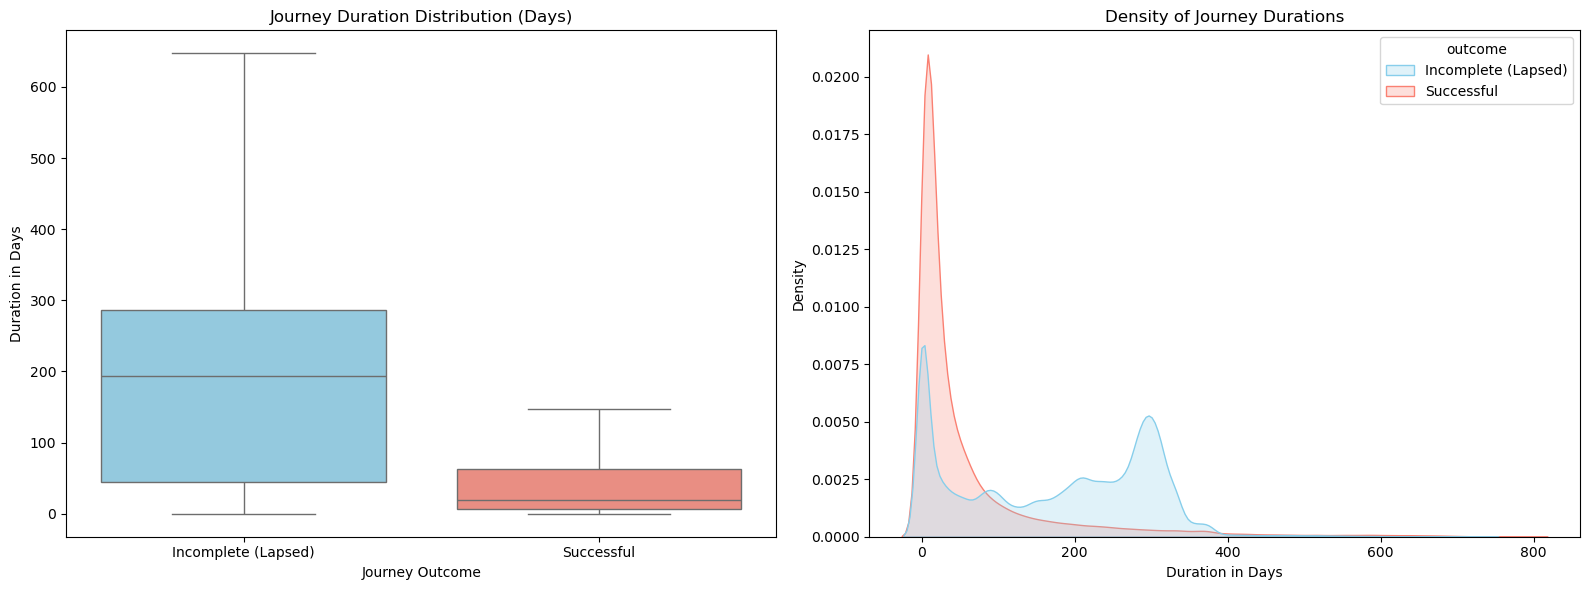

In [28]:
# Filter for the two main comparison groups
df_viz = df_final[df_final['outcome'].isin(['Successful', 'Incomplete (Lapsed)'])].copy()

# Convert seconds to days for better readability on the graph
df_viz['duration_days'] = df_viz['journey_duration_sec'] / (24 * 3600)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Boxplot - Great for comparing medians and spreads
sns.boxplot(ax=axes[0], x='outcome', y='duration_days', data=df_viz, 
            showfliers=False, palette=['skyblue', 'salmon'])
axes[0].set_title('Journey Duration Distribution (Days)')
axes[0].set_ylabel('Duration in Days')
axes[0].set_xlabel('Journey Outcome')

# 2. KDE Plot - Great for seeing the "shape" of the time spent
sns.kdeplot(ax=axes[1], data=df_viz, x='duration_days', hue='outcome', 
            fill=True, common_norm=False, palette=['skyblue', 'salmon'])
axes[1].set_title('Density of Journey Durations')
axes[1].set_xlabel('Duration in Days')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [29]:
# A. Identify successful journey end-times
success_times = df_clean[df_clean['customer_id'].isin(success_ids)].groupby('customer_id').agg(
    start_time=('event_timestamp', 'min'),
    end_time=('event_timestamp', lambda x: x[df_clean.loc[x.index, 'event_name'] == 'order_shipped'].min())
)

# B. Generate the random snapshot/cut time
np.random.seed(42)
def get_random_time(row):
    start = row['start_time'].value 
    end = row['end_time'].value
    if start >= end:
        return pd.to_datetime(start, utc=True)
    random_val = np.random.randint(start, end)
    return pd.to_datetime(random_val, utc=True)

success_times['cut_time'] = success_times.apply(get_random_time, axis=1)

# C. Apply the cut to create df_train_pos_raw
df_success_full = df_clean[df_clean['customer_id'].isin(success_ids)].merge(
    success_times[['cut_time']], on='customer_id'
)

df_train_pos_raw = df_success_full[
    (df_success_full['event_timestamp'] < df_success_full['cut_time']) & 
    (df_success_full['event_name'] != 'order_shipped')
].copy()

In [30]:
# 1. Flatten the Truncated Positive Data (Label 1)
df_train_pos = df_train_pos_raw.groupby('customer_id').agg(
    total_actions=('journey_steps_until_end', 'max'),
    has_applied=('is_appl_submit', 'max'),
    max_items_in_cart=('is_add_to_cart', 'sum'),
    num_unique_products=('is_browse', 'sum')
).reset_index()
df_train_pos['label'] = 1

# 2. Prepare the Incomplete Journeys (Label 0)
# Use your df_final from Task 1 which already identified 'Incomplete (Lapsed)'
df_train_neg = df_final[df_final['outcome'] == 'Incomplete (Lapsed)'][
    ['customer_id', 'total_actions', 'has_applied', 'max_items_in_cart', 'num_unique_products']
].copy()
df_train_neg['label'] = 0

# 3. Combine and Shuffle
df_train = pd.concat([df_train_pos, df_train_neg], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
df_train.head()

,customer_id,total_actions,has_applied,max_items_in_cart,num_unique_products,label
0,490811068,16,1,0,2,0
1,-1315983861,35,0,3,12,0
2,-1331267367,26,1,2,3,0
3,-867961387,75,0,8,32,0
4,312725333,55,0,5,22,0


In [32]:
def add_time_features(df, cut_col='cut_time'):
    # 1. Recency: Seconds between the 'snapshot' and the very last action before that snapshot
    last_action_time = df.groupby('customer_id')['event_timestamp'].transform('max')
    df['recency_seconds'] = (df[cut_col] - last_action_time).dt.total_seconds()

    # 2. Frequency: Total actions in the 24 hours immediately preceding the cut
    day_before_cut = df[cut_col] - pd.Timedelta(days=1)
    df['is_last_24h'] = (df['event_timestamp'] >= day_before_cut).astype(int)
    
    # 3. Time of Day: The hour of the day when the snapshot occurred
    df['snapshot_hour'] = df[cut_col].dt.hour
    
    return df

In [33]:
# Prepare Negative Raw Data
incomplete_ids = df_final[df_final['outcome'] == 'Incomplete (Lapsed)']['customer_id'].unique()
df_train_neg_raw = df_clean[df_clean['customer_id'].isin(incomplete_ids)].copy()

# For Negative journeys, the 'cut_time' is simply their last recorded event
df_train_neg_raw['cut_time'] = df_train_neg_raw.groupby('customer_id')['event_timestamp'].transform('max')

# Apply features to both
df_train_pos_raw = add_time_features(df_train_pos_raw, cut_col='cut_time')
df_train_neg_raw = add_time_features(df_train_neg_raw, cut_col='cut_time')

In [34]:
df_train_pos_raw.head()

,customer_id,account_id,ed_id,event_name,event_timestamp,journey_steps_until_end,id,sep,time_diff,hour,is_appl_submit,is_shipped,is_add_to_cart,is_browse,cut_time,recency_seconds,is_last_24h,snapshot_hour
0,-2147425125,221594945,2,campaign_click,2021-09-25 06:00:00+00:00,1,-2147425125 221594945,-,NaT,6,0,0,0,0,2021-09-25 07:01:34.459720974+00:00,3694.459721,1,7
32,-2147395611,674764100,29,account_activitation,2021-06-15 00:00:00+00:00,1,-2147395611 674764100,-,NaT,0,0,0,0,0,2021-06-17 17:28:55.489845369+00:00,62935.489845,0,17
33,-2147395611,674764100,2,campaign_click,2021-06-15 06:00:00+00:00,2,-2147395611 674764100,-,0 days 06:00:00,6,0,0,0,0,2021-06-17 17:28:55.489845369+00:00,62935.489845,0,17
34,-2147395611,674764100,12,application_web_approved,2021-06-15 16:38:39+00:00,3,-2147395611 674764100,-,0 days 10:38:39,16,0,0,0,0,2021-06-17 17:28:55.489845369+00:00,62935.489845,0,17
35,-2147395611,674764100,4,browse_products,2021-06-15 16:42:43+00:00,4,-2147395611 674764100,-,0 days 00:04:04,16,0,0,0,1,2021-06-17 17:28:55.489845369+00:00,62935.489845,0,17


In [35]:
def flatten_with_bonus(df):
    return df.groupby('customer_id').agg(
        total_actions=('journey_steps_until_end', 'max'),
        has_applied=('is_appl_submit', 'max'),
        max_items_in_cart=('is_add_to_cart', 'sum'),
        num_unique_products=('is_browse', 'sum'),
        # Bonus predictors
        recency=('recency_seconds', 'min'),    
        frequency_24h=('is_last_24h', 'sum'),  
        snapshot_hour=('snapshot_hour', 'first')
    ).reset_index()

# Flatten and Combine
df_train_pos = flatten_with_bonus(df_train_pos_raw)
df_train_pos['label'] = 1

df_train_neg = flatten_with_bonus(df_train_neg_raw)
df_train_neg['label'] = 0

df_train = pd.concat([df_train_pos, df_train_neg], ignore_index=True)

In [36]:
df_train

,customer_id,total_actions,has_applied,max_items_in_cart,num_unique_products,recency,frequency_24h,snapshot_hour,label
0,-2147425125,1,0,0,0,3694.459721,1,7,1
1,-2147395611,18,0,2,8,62935.489845,1,17,1
2,-2147395574,21,0,1,2,79483.558459,1,22,1
3,-2147387154,35,0,4,16,53098.939488,6,14,1
4,-2147379618,28,1,0,2,38341.815348,1,10,1
...,...,...,...,...,...,...,...,...,...
1235139,2147473559,15,0,0,2,0.000000,2,21,0
1235140,2147475768,55,0,3,28,0.000000,1,8,0
1235141,2147480051,14,0,0,0,0.000000,1,1,0
1235142,2147480920,106,1,7,52,0.000000,1,16,0


# Assignment 4

## Task 4

In [37]:
# 2. The Last Mile: What was their very last act?
# Combine the raw data chunks to look at event sequences
raw_combined = pd.concat([df_train_pos_raw, df_train_neg_raw])
# Get only the final event for every customer
last_events = raw_combined.sort_values(['customer_id', 'event_timestamp']).groupby('customer_id').tail(1)

# Merge labels back in from your flattened df_train
last_events = last_events.merge(df_train[['customer_id', 'label']], on='customer_id')

# Compare the top 5 "Exit Events" for Lapsed users vs Success users
lapsed_exits = last_events[last_events['label'] == 0]['event_name'].value_counts(normalize=True).head(5)
success_exits = last_events[last_events['label'] == 1]['event_name'].value_counts(normalize=True).head(5)

print("--- Top 5 Exit Events (Lapsed Users) ---")
print(lapsed_exits)
print("\n--- Top 5 Exit Events (Successful Users) ---")
print(success_exits)

--- Top 5 Exit Events (Lapsed Users) ---
event_name
promotion_created           0.481428
catalog_(mail)              0.204374
browse_products             0.100962
campaign_click              0.038343
application_web_approved    0.034709
Name: proportion, dtype: float64

--- Top 5 Exit Events (Successful Users) ---
event_name
account_downpaymentcleared    0.191508
browse_products               0.178378
promotion_created             0.153407
campaignemail_clicked         0.072942
catalog_(mail)                0.071706
Name: proportion, dtype: float64


Total users ending on promotion_created: 503375

--- Time Lag (Minutes) between Previous Event and Promotion Created ---
          count          mean           std  min           25%           50%  \
label                                                                          
0      460696.0  73595.029342  79216.476020  0.0  22025.383333  42492.033333   
1       41097.0  13417.681431  27728.721503  0.0     31.083333   1634.433333   

                 75%            90%            max  
label                                               
0      112751.366667  199102.916667  542514.516667  
1       16220.600000   42499.006667  438311.883333  

--- Top 5 'Real' Last Events (The action right before Promotion Created) ---

Lapsed Users:
prev_event_name
promotion_created    0.472991
catalog_(mail)       0.338427
browse_products      0.056278
begin_checkout       0.039651
view_cart            0.032831
Name: proportion, dtype: float64

Successful Users:
prev_event_name
promotion_created  

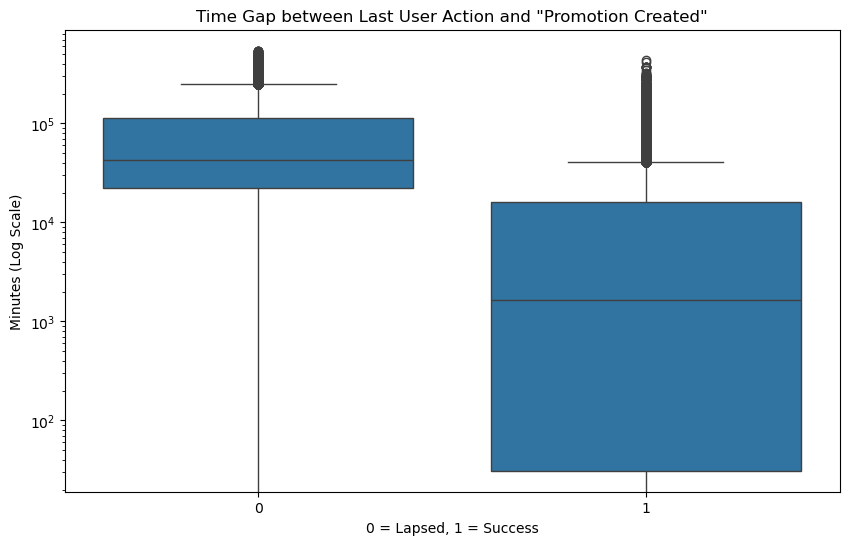

In [38]:
# --- INVESTIGATING THE "PROMOTION CLIFF" ---

# 1. Ensure raw_combined is sorted and has labels
raw_combined = raw_combined.sort_values(['customer_id', 'event_timestamp'])
if 'label' not in raw_combined.columns:
    raw_combined = raw_combined.merge(df_train[['customer_id', 'label']], on='customer_id', how='left')

# 2. Identify the last and second-to-last event for every user
# We use shift(1) to get the event and timestamp immediately preceding the current one
raw_combined['prev_event_name'] = raw_combined.groupby('customer_id')['event_name'].shift(1)
raw_combined['prev_event_timestamp'] = raw_combined.groupby('customer_id')['event_timestamp'].shift(1)

# 3. Calculate the time delta (in minutes) between events
raw_combined['time_delta_mins'] = (raw_combined['event_timestamp'] - raw_combined['prev_event_timestamp']).dt.total_seconds() / 60

# 4. Isolate the "Last Mile" specifically
# Get the very last row for each customer
last_mile_detailed = raw_combined.groupby('customer_id').tail(1)

# 5. Filter for users whose journey ended on 'promotion_created'
promo_exits = last_mile_detailed[last_mile_detailed['event_name'] == 'promotion_created'].copy()

print(f"Total users ending on promotion_created: {len(promo_exits)}")

# 6. Analyze the Time Lag for Lapsed vs Successful Users
print("\n--- Time Lag (Minutes) between Previous Event and Promotion Created ---")
lag_stats = promo_exits.groupby('label')['time_delta_mins'].describe(percentiles=[.25, .5, .75, .9])
print(lag_stats)

# 7. What was the user's REAL last action before the promotion was created?
print("\n--- Top 5 'Real' Last Events (The action right before Promotion Created) ---")
for lbl in [0, 1]:
    group_name = "Lapsed" if lbl == 0 else "Successful"
    print(f"\n{group_name} Users:")
    print(promo_exits[promo_exits['label'] == lbl]['prev_event_name'].value_counts(normalize=True).head(5))

# 8. Visualizing the Lag
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='time_delta_mins', data=promo_exits)
plt.yscale('log') # Use log scale if there are massive outliers (e.g., promotions created days later)
plt.title('Time Gap between Last User Action and "Promotion Created"')
plt.ylabel('Minutes (Log Scale)')
plt.xlabel('0 = Lapsed, 1 = Success')
plt.show()

In [39]:
# Calculate the 'silence' periods for successful users
# This looks for the time between any two consecutive events for success cases
success_raw = raw_combined[raw_combined['label'] == 1].copy()
success_raw['gap'] = success_raw.groupby('customer_id')['event_timestamp'].diff().dt.total_seconds() / 3600 # in hours

print("--- Gap Analysis for Successful Users (Hours) ---")
print(success_raw['gap'].describe(percentiles=[.5, .75, .9, .95]))

# The 90th percentile here tells you: "If a user is gone for X hours, 
# 90% of people who actually buy have already come back."

--- Gap Analysis for Successful Users (Hours) ---
count    8.421507e+06
mean     1.584541e+01
std      1.060956e+02
min      0.000000e+00
50%      1.722222e-02
75%      9.666667e-02
90%      9.171667e+00
95%      5.098083e+01
max      1.309657e+04
Name: gap, dtype: float64


--- PROMOTION SUCCESS RATE BY DELAY ---
delay_bucket
Initial Offer    99.834433
< 1 Hour         96.531839
1-6 Hours        97.831973
6-24 Hours       99.230307
24-48 Hours      96.655797
> 2 Days         89.620412
Name: returned_after_promo, dtype: float64


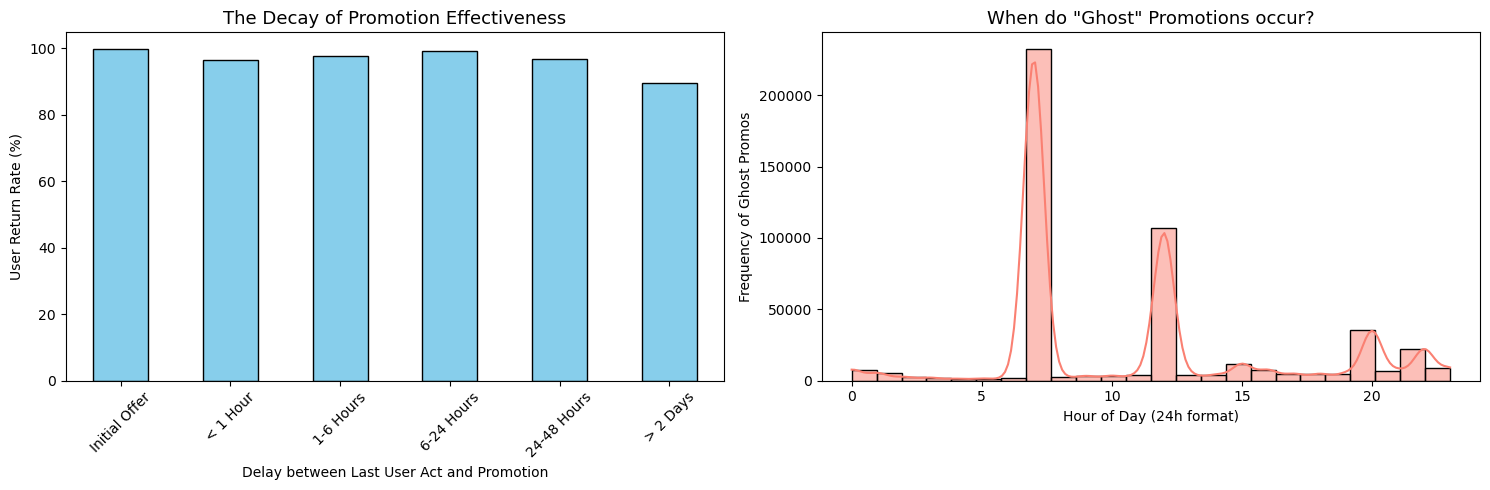

In [46]:
# --- NEW DIRECTION: THE PROMOTION EFFECTIVENESS CURVE ---

# 1. Ensure timestamps are correct and data is sorted
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
df_sorted = df.sort_values(['customer_id', 'event_timestamp'])

# 2. Identify all promotions and calculate the "Recency" (Time since user's last act)
df_sorted['prev_timestamp'] = df_sorted.groupby('customer_id')['event_timestamp'].shift(1)
df_sorted['promo_delay_hours'] = (df_sorted['event_timestamp'] - df_sorted['prev_timestamp']).dt.total_seconds() / 3600

# 3. Determine if the user 'Returned' after the promotion
# We check if this promotion was the absolute last event for the user
df_sorted['is_last_event'] = df_sorted.groupby('customer_id')['event_timestamp'].rank(method='first', ascending=False) == 1
df_sorted['returned_after_promo'] = ~df_sorted['is_last_event']

# 4. Isolate only the promotion events for analysis
all_promos = df_sorted[df_sorted['event_name'] == 'promotion_created'].copy()

# 5. Create Time-Delay Buckets (e.g., <1hr, 1-6hr, 6-24hr, etc.)
def bucket_delay(hours):
    if pd.isna(hours): return 'Initial Offer'
    if hours <= 1: return '< 1 Hour'
    if hours <= 6: return '1-6 Hours'
    if hours <= 24: return '6-24 Hours'
    if hours <= 48: return '24-48 Hours'
    return '> 2 Days'

all_promos['delay_bucket'] = all_promos['promo_delay_hours'].apply(bucket_delay)

# 6. CALCULATE SUCCESS RATE: What % of users return after a promo, based on delay?
success_by_delay = all_promos.groupby('delay_bucket')['returned_after_promo'].mean() * 100

# Reorder the results so the chart flows logically
order = ['Initial Offer', '< 1 Hour', '1-6 Hours', '6-24 Hours', '24-48 Hours', '> 2 Days']
success_by_delay = success_by_delay.reindex(order)

# 7. BATCH JOB DETECTION: Check the hour of day for terminal (Ghost) promotions
ghost_promos = all_promos[all_promos['returned_after_promo'] == False].copy()
ghost_promos['hour_of_day'] = ghost_promos['event_timestamp'].dt.hour
hour_dist = ghost_promos['hour_of_day'].value_counts(normalize=True).sort_index()

# --- PRINT RESULTS ---
print("--- PROMOTION SUCCESS RATE BY DELAY ---")
print(success_by_delay)

# --- VISUALIZATION ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
# Use the series index and values directly for the plot
success_by_delay.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('The Decay of Promotion Effectiveness', fontsize=13)
plt.ylabel('User Return Rate (%)')
plt.xlabel('Delay between Last User Act and Promotion')
plt.xticks(rotation=45) # Rotated labels for better readability

plt.subplot(1, 2, 2)
sns.histplot(ghost_promos['hour_of_day'], bins=24, kde=True, color='salmon')
plt.title('When do "Ghost" Promotions occur?', fontsize=13)
plt.xlabel('Hour of Day (24h format)')
plt.ylabel('Frequency of Ghost Promos')

plt.tight_layout()
plt.show()

/var/folders/9d/172d12fx165by8w23sfqj4400000gn/T/ipykernel_12958/1078928696.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=termination_stats.index, y=termination_stats.values, palette="OrRd", edgecolor='black')


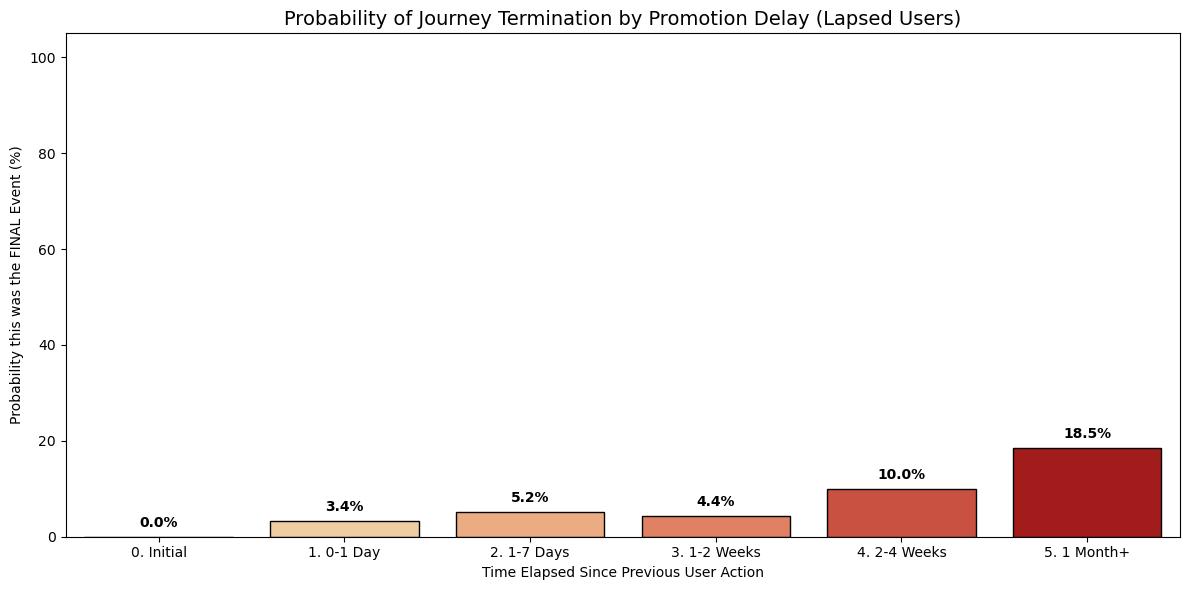

In [49]:
# --- THE GHOST PROBABILITY CHART ---

# 1. Merge labels if missing
if 'label' not in df_sorted.columns:
    df_sorted = df_sorted.merge(df_train[['customer_id', 'label']], on='customer_id', how='left')

# 2. Filter for Lapsed Users and ALL their promotion events
lapsed_promos = df_sorted[(df_sorted['label'] == 0) & (df_sorted['event_name'] == 'promotion_created')].copy()

# 3. Create the granular "Long Tail" bins
def ghost_bins(hours):
    if pd.isna(hours): return '0. Initial'
    days = hours / 24
    if days <= 1:  return '1. 0-1 Day'
    if days <= 7:  return '2. 1-7 Days'
    if days <= 14: return '3. 1-2 Weeks'
    if days <= 30: return '4. 2-4 Weeks'
    return '5. 1 Month+'

lapsed_promos['delay_bucket'] = lapsed_promos['promo_delay_hours'].apply(ghost_bins)

# 4. CALCULATE TERMINATION RATE: 
# % of promotions in this bucket that were the ABSOLUTE FINAL event for the user
termination_stats = lapsed_promos.groupby('delay_bucket')['is_last_event'].mean() * 100

# 5. Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=termination_stats.index, y=termination_stats.values, palette="OrRd", edgecolor='black')

plt.title('Probability of Journey Termination by Promotion Delay (Lapsed Users)', fontsize=14)
plt.ylabel('Probability this was the FINAL Event (%)')
plt.xlabel('Time Elapsed Since Previous User Action')
plt.ylim(0, 105)

for i, v in enumerate(termination_stats):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

/var/folders/9d/172d12fx165by8w23sfqj4400000gn/T/ipykernel_12958/1342384090.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/miniconda3/envs/statsm148/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


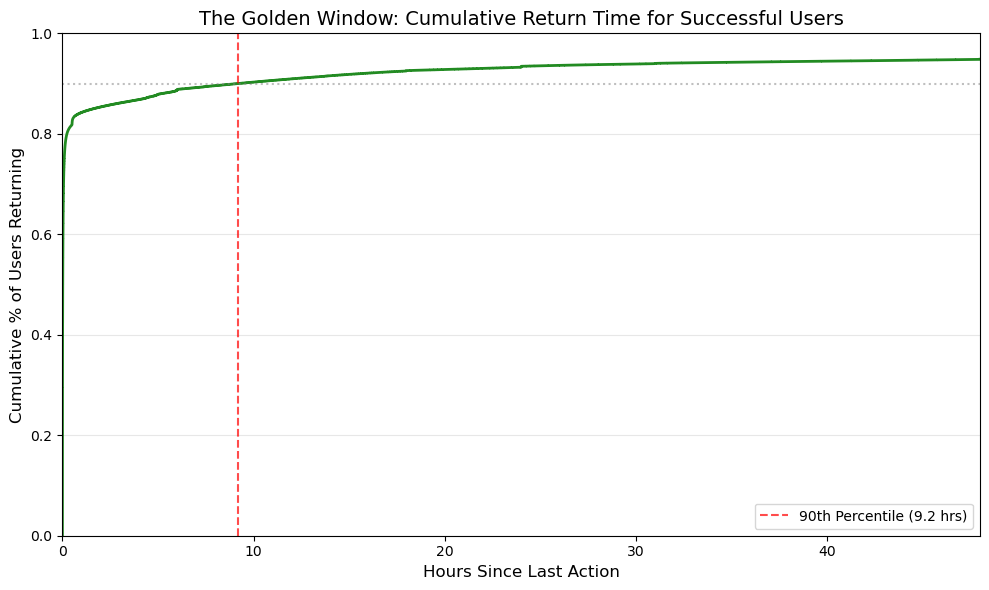

In [50]:
# --- THE "GOLDEN WINDOW" CHART: CUMULATIVE RETURN PROBABILITY ---

# 1. Filter for successful users and calculate gaps (in hours)
# Assuming 'raw_combined' from previous steps is available
success_gaps = raw_combined[raw_combined['label'] == 1].copy()
success_gaps['gap_hours'] = success_gaps.groupby('customer_id')['event_timestamp'].diff().dt.total_seconds() / 3600
success_gaps = success_gaps.dropna(subset=['gap_hours'])

# 2. Plotting the Cumulative Distribution
plt.figure(figsize=(10, 6))

# We use a histogram with 'cumulative=True' to create the CDF
# We limit the X-axis to 48 hours to focus on the 'active' window
sns.ecdfplot(data=success_gaps, x='gap_hours', color='forestgreen', linewidth=2)

# 3. Add the 9-Hour Threshold line
threshold = 9.17
plt.axvline(x=threshold, color='red', linestyle='--', alpha=0.7, label=f'90th Percentile ({threshold:.1f} hrs)')
plt.axhline(y=0.90, color='gray', linestyle=':', alpha=0.5)

# Formatting
plt.title('The Golden Window: Cumulative Return Time for Successful Users', fontsize=14)
plt.xlabel('Hours Since Last Action', fontsize=12)
plt.ylabel('Cumulative % of Users Returning', fontsize=12)
plt.xlim(0, 48) # Focus on the first 2 days
plt.grid(axis='y', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()